In [1]:
import numpy as np
import pandas as pd
import copy
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import sys
from sklearn.preprocessing import Imputer
%matplotlib inline  
pd.set_option('display.max_columns', 400)

In [2]:
def str_to_num_helper(text):
    try:
        num = float(re.sub(r"[^0-9.]", r"", text))
    except:
        num = np.nan
    return num

In [3]:
def str_to_num(df, varname):
    
    return(df[varname].map(lambda x: str_to_num_helper(x)))

In [4]:
def get_agg (df, yr, col_for_agg):
    """
    limitation: works on my data with specific cols
    output: one row of aggregated statistics as pandas DataFrame
    """
    if yr:
        agg_df = pd.DataFrame(df.loc[df['yr_diff'] <= yr, col_for_agg].mean())
    else:
        agg_df = pd.DataFrame(df.loc[:, col_for_agg].mean())
    agg_df = agg_df.reset_index()
    agg_df = agg_df.pivot(index = [0] * 5, columns='index', values=0)
    if yr:
        agg_df.columns = agg_df.columns + "_" + str(yr) + "yr" 
    else:
        agg_df.columns = agg_df.columns + "_allyr"
    return agg_df

In [5]:
def get_player_history (plr_df, movieid, role, playerid):
    if pd.isnull(playerid):
        return None
    else:
        d_cond = plr_df['movieid'] == movieid
        max_date = plr_df.loc[d_cond, 'release_date'].iloc[0]
        ap_cond = (plr_df['role'] == role) & (plr_df['playerid'] == playerid) & (plr_df['release_date'] < max_date)
        plr_cols = ['movieid', 'log_life_gross', 'life_theater', 'log_open_gross', 'open_theater', 'release_date', \
                    'release_yr', 'release_mon', 'release_wday_num', 'rank_num']
        df = plr_df.loc[ap_cond, plr_cols]
        df = df.sort_values(by = 'release_date', ascending = False)

        df['yr_diff'] = ((max_date - df['release_date']).dt.days / 365).map(np.ceil)
        col_for_agg = ['log_life_gross', 'life_theater', 'log_open_gross', 'open_theater', 'rank_num']
        plr_stats = get_agg(df, 1, col_for_agg)
        plr_stats = plr_stats.merge(get_agg(df, 3, col_for_agg), left_index = True, right_index=True)
        plr_stats = plr_stats.merge(get_agg(df, 5, col_for_agg), left_index = True, right_index=True)
        plr_stats = plr_stats.merge(get_agg(df, None, col_for_agg), left_index = True, right_index=True)

        plr_stats.loc[:, 'movieid'] = movieid
        plr_stats.loc[:, 'role'] = role
        plr_stats.loc[:, 'playerid'] = playerid
        return plr_stats

# import data

In [6]:
with open("my_data.pkl", 'rb') as picklefile: 
    gross_df = pickle.load(picklefile).drop_duplicates()
    meta_df = pickle.load(picklefile).drop_duplicates()
    movie_main = pickle.load(picklefile).drop_duplicates()
    player_gross_df = pickle.load(picklefile).drop_duplicates()
    player_meta_df = pickle.load(picklefile).drop_duplicates()
    players_df = pickle.load(picklefile).drop_duplicates()

# cleaning

In [ ]:
#TODO use only training for studio ranking
#save training mean/min/.. to impute testing

In [48]:
#clean player_gross_df
player_gross_df['plr_life_mv_num'] = str_to_num(player_gross_df, 'plr_life_mv_num')
player_gross_df['plr_log_life_gross'] = str_to_num(player_gross_df, 'plr_life_gross').map(np.log)
player_gross_df['plr_log_avg_gross'] = str_to_num(player_gross_df, 'plr_avg_gross').map(np.log)
player_gross_df['plr_open_mv_num'] = str_to_num(player_gross_df, 'plr_open_mv_num')
player_gross_df['plr_log_avg_open_gross'] = str_to_num(player_gross_df, 'plr_avg_open_gross').map(np.log)
del player_gross_df['plr_life_gross'], player_gross_df['plr_avg_gross'], player_gross_df['plr_avg_open_gross']

In [49]:
#clean player_meta_df
cond_na = player_meta_df['release_date'] == 'N/A'
player_meta_df.loc[cond_na, 'release_date_num'] = np.nan
player_meta_df.loc[~cond_na, 'release_date_num'] = pd.to_datetime(player_meta_df.loc[~cond_na, 'release_date'])
del player_meta_df['release_date']
player_meta_df = player_meta_df.rename(index = str, columns = {'release_date_num': 'release_date'})
player_meta_df['release_yr'] = player_meta_df['release_date'].dt.year
player_meta_df['release_mon'] = player_meta_df['release_date'].dt.month
player_meta_df['release_wday_num'] = player_meta_df['release_date'].map(lambda x: x.isoweekday())

player_meta_df['log_life_gross'] = str_to_num(player_meta_df, 'life_gross').map(np.log)
player_meta_df['life_theater'] = str_to_num(player_meta_df, 'life_theater')
player_meta_df['log_open_gross'] = str_to_num(player_meta_df, 'open_gross').map(np.log)
player_meta_df['open_theater'] = str_to_num(player_meta_df, 'open_theater')
del player_meta_df['life_gross'], player_meta_df['open_gross']

cond = player_meta_df['Rank'] != '-'
player_meta_df.loc[cond, 'rank_num'] = pd.to_numeric(player_meta_df.loc[cond,'Rank'])
del player_meta_df['Rank']

In [50]:
#clean movie_main
cond = movie_main['Rank'] != '-'
movie_main.loc[cond, 'rank_num'] = pd.to_numeric(movie_main.loc[cond,'Rank'])
del movie_main['Rank']

movie_main['life_theater'] = str_to_num(movie_main, 'life_theater')
movie_main['open_theater'] = str_to_num(movie_main, 'open_theater')

movie_main['log_life_gross'] = str_to_num(movie_main, 'life_gross').map(np.log)
movie_main['log_open_gross'] = str_to_num(movie_main, 'open_gross').map(np.log)
del movie_main['life_gross'], movie_main['open_gross']

movie_main['release_date'] = pd.to_datetime(movie_main['release_date'])
movie_main['release_yr'] = movie_main['release_date'].dt.year
movie_main['release_wday_num'] = movie_main['release_date'].map(lambda x: x.isoweekday())

movie_main['release_mon'] = movie_main['release_date'].dt.month
movie_main['release_mon2'] = movie_main['release_mon'].map(lambda x: x ** 2)
movie_main['release_mon3'] = movie_main['release_mon'].map(lambda x: x ** 3)

movie_main.loc[:, 'genre_sd'] = movie_main['genre'] == 'summerdrama'
movie_main.loc[:, 'genre_cm'] = movie_main['genre'] == 'crime'
movie_main.loc[:, 'genre_r'] = movie_main['genre'] == 'r-ratedcomedy'
movie_main.loc[:, 'genre_cp'] = movie_main['genre'] == 'caper'
#del movie_main['genre']

In [51]:
#clean gross_df
gross_df['log_life_frn_gross'] = str_to_num(gross_df, 'life_frn_gross').map(np.log)
gross_df['log_avg_open_gross'] = str_to_num(gross_df, 'avg_open_gross').map(np.log)
gross_df['pct_open_gross'] = gross_df['pct_open_gross'].map(float)
del gross_df['life_frn_gross'], gross_df['avg_open_gross']

In [7]:
gross_df.head()

life_frn_gross avg_open_gross       pct_open_gross            movieid
0    347,693,217        15,329   0.07400000000000001        forrestgump
1    265,300,000        12,414                 0.141  savingprivateryan
2    250,678,391        18,381                 0.298        pearlharbor
3    269,935,000        11,851                 0.185          gladiator
4    146,100,000        12,129                 0.226       perfectstorm

In [52]:
#clean meta_df
meta_df.loc[:, 'mpaa_pg13'] = meta_df['mpaa'] == 'PG-13'
meta_df.loc[:, 'mpaa_pg'] = meta_df['mpaa'] == 'PG'
cond = meta_df['mpaa'] == 'Unrated'
meta_df.loc[cond, ['mpaa_pg13', 'mpaa_pg']] = np.nan 
del meta_df['mpaa']

pattern = r"(?P<hr>[0-9]+?) hrs. (?P<min>[0-9]+?) min"
mv_hr, mv_min = list(zip(*meta_df['runtime'].map(lambda x: re.search(pattern, x).groups())))
meta_df['runtime_mins'] = np.array([int(x) * 60 for x in mv_hr]) + np.array([int(x) for x in mv_min])
del meta_df['runtime']

million = meta_df['budget'].map(lambda x: bool(re.match(r" *[0-9.]* *million *", x)))
meta_df.loc[million, 'budget_num'] = meta_df.loc[million, 'budget'].map(lambda x: float(re.sub(r"[^0-9.]", r"", x)) * 10 ** 6)
meta_df.loc[~million, 'budget_num'] = meta_df.loc[~million, 'budget'].map(lambda x: float(re.sub(r"[^0-9.]", r"", x)))
meta_df['log_budget_num'] = meta_df['budget_num'].map(np.log)
del meta_df['budget'], meta_df['budget_num']


In [53]:
#get movie df - one row per movie
movie = movie_main.merge(meta_df, how = 'left', on = 'movieid')
movie = movie.merge(gross_df, how = 'left', on = 'movieid')

In [54]:
movie['ww_log_life_gross'] = (movie['log_life_gross'].map(np.exp) + movie['log_life_frn_gross'].map(np.exp)).map(np.log)
movie['pct_life_gross'] = movie['log_life_gross'].map(np.exp) / movie['ww_log_life_gross'].map(np.exp)

In [55]:
movie['n_miss_mv_cols'] = movie.isnull().sum(axis=1)

In [56]:
#get movie-player df - one row per movie-role-player
movie_player = movie.merge(players_df, how = 'left', on = 'movieid')
movie_player = movie_player.merge(player_gross_df, how = 'left', on = ['role', 'playerid'])

In [57]:
#get a set b/c same movie can be listed under multiple genres
plr_set = movie_player.loc[:, ['movieid', 'role', 'playerid']].drop_duplicates()
plr_set = plr_set.reset_index(drop = True)

In [58]:
#get player history 
wide = pd.DataFrame()
for i in range(plr_set.shape[0]):
    one_row = plr_set.iloc[i]
    wide = wide.append(get_player_history(player_meta_df, one_row['movieid'], one_row['role'], one_row['playerid']))
wide = wide.reset_index(drop = True)

In [59]:
movie_player = movie_player.merge(wide, how = 'left', on = ['movieid', 'role', 'playerid'])

In [60]:
movie_player['log_life_gross_diff31'] = movie_player['log_life_gross_3yr'] - movie_player['log_life_gross_1yr']
movie_player['log_open_gross_diff31'] = movie_player['log_open_gross_3yr'] - movie_player['log_open_gross_1yr']

movie_player['log_life_gross_diff53'] = movie_player['log_life_gross_5yr'] - movie_player['log_life_gross_3yr']
movie_player['log_open_gross_diff53'] = movie_player['log_open_gross_5yr'] - movie_player['log_open_gross_3yr']

In [9]:
#rank studio
rank_stu = player_meta_df[player_meta_df['Studio'] != 'N/A']
rank_stu = pd.DataFrame(player_meta_df['Studio'].value_counts())
rank_stu['rank_stu'] = rank_stu.rank(axis = 0, method = 'dense')
rank_stu['rank_stu2'] = rank_stu['rank_stu'].map(lambda x: x ** 2)
rank_stu['rank_stu3'] = rank_stu['rank_stu'].map(lambda x: x ** 3)
rank_stu.reset_index(inplace = True)
rank_stu = rank_stu.rename(index = str, columns = {'Studio': 'studio_mv_ct', 'index': 'Studio'})

In [62]:
movie_player = movie_player.merge(rank_stu, how = "left", on = 'Studio')
#del movie_player['Studio']

In [63]:
#player rank
ct = pd.DataFrame(players_df.groupby(['movieid', 'role']).cumcount())
rank_plr = players_df.merge(ct, left_index = True, right_index = True)
rank_plr = rank_plr.rename(index = str, columns = {0: 'rank_plr'})

In [64]:
#filter out lower ranked players
movie_filtered = movie_player.merge(rank_plr, how = 'left', on = ['movieid', 'role', 'playerid', 'player'])
kickout = ((movie_filtered['role'].isin(['Producer', 'Director', 'Writer'])) & (movie_filtered['rank_plr'] > 0)) | \
          ((movie_filtered['role'] == 'Actor') & (movie_filtered['rank_plr'] > 1))    
movie_filtered = movie_filtered.loc[~kickout]
movie_filtered.loc[:, 'rank_plr_ch'] = movie_filtered['rank_plr'].astype(str)

# missing data

In [ ]:
#systematic missing: more missing in lowest ranked movies

In [ ]:
#TODO should I fill na and rank variables on only training data?

In [65]:
for col in ['log_life_gross', 'life_theater', 'log_open_gross', 'open_theater', 'log_budget_num', 'log_life_frn_gross', \
           'log_avg_open_gross', 'ww_log_life_gross', 'plr_life_mv_num', 'plr_log_life_gross', 'plr_log_avg_gross', \
           'plr_open_mv_num', 'plr_log_avg_open_gross',
           'log_life_gross_1yr', 'life_theater_1yr', 'log_open_gross_1yr', 'open_theater_1yr', \
            'log_life_gross_3yr', 'life_theater_3yr', 'log_open_gross_3yr', 'open_theater_3yr', \
            'log_life_gross_5yr', 'life_theater_5yr', 'log_open_gross_5yr', 'open_theater_5yr', \
            'log_life_gross_allyr', 'life_theater_allyr', 'log_open_gross_allyr', 'open_theater_allyr']:
    movie_filtered.loc[:, col] = movie_filtered.groupby('genre').transform(lambda x: x.fillna(x.min())).loc[:, col]

In [66]:
for col in ['rank_num', 'rank_num_1yr', 'rank_num_3yr','rank_num_5yr', 'rank_num_allyr']:
    movie_filtered.loc[:, col] = movie_filtered.groupby('genre').transform(lambda x: x.fillna(x.max())).loc[:, col]

In [67]:
for col in ['mpaa_pg13', 'mpaa_pg']:
    movie_filtered.loc[:, col] = movie_filtered.groupby('genre').transform(lambda x: x.fillna(False)).loc[:, col]

In [68]:
for col in ['runtime_mins', 'pct_open_gross', 'pct_life_gross', 'log_life_gross_diff31', 'log_open_gross_diff31', \
           'log_life_gross_diff53', 'log_open_gross_diff53']:
    movie_filtered.loc[:, col] = movie_filtered.groupby('genre').transform(lambda x: x.fillna(np.nanmedian(x))).loc[:, col]

In [69]:
for col in ['studio_mv_ct', 'rank_stu', 'rank_stu2', 'rank_stu3']:
    movie_filtered.loc[:, col] = movie_filtered.groupby('genre').transform(lambda x: x.fillna(1)).loc[:, col]

# final data

In [70]:
by_cols = ['movieid', 'log_life_gross', 'life_theater', 'log_open_gross', 'open_theater', 'n_miss_mv_cols', \
           'rank_num', 'release_yr', 'release_mon', 'release_mon2', 'release_mon3', 'release_wday_num', \
           'genre_sd', 'genre_cm', 'genre_r', 'genre_cp', 'mpaa_pg13', 'mpaa_pg', 'runtime_mins', \
           'log_budget_num', 'log_life_frn_gross', 'log_avg_open_gross', 'pct_open_gross', 'ww_log_life_gross', \
           'pct_life_gross', 'studio_mv_ct', 'rank_stu', 'rank_stu2', 'rank_stu3'] 
transpose_cols = ['role', 'rank_plr_ch']
val_cols = ['plr_life_mv_num', 'plr_log_life_gross', 'plr_log_avg_gross', 'plr_open_mv_num', 'plr_log_avg_open_gross', \
            'log_life_gross_1yr', 'life_theater_1yr', 'log_open_gross_1yr', 'open_theater_1yr', 'rank_num_1yr', \
            'log_life_gross_3yr', 'life_theater_3yr', 'log_open_gross_3yr', 'open_theater_3yr', 'rank_num_3yr', \
            'log_life_gross_5yr', 'life_theater_5yr', 'log_open_gross_5yr', 'open_theater_5yr', 'rank_num_5yr', \
            'log_life_gross_allyr', 'life_theater_allyr', 'log_open_gross_allyr', 'open_theater_allyr', \
            'rank_num_allyr', 'log_life_gross_diff31', 'log_open_gross_diff31', 'log_life_gross_diff53', \
            'log_open_gross_diff53'] 
keep = (movie_filtered['role'].isin(['Producer', 'Director', 'Writer', 'Actor'])) 
mv_piv = pd.pivot_table(movie_filtered.loc[keep], index = 'movieid', columns = transpose_cols, values = val_cols)
mv_piv.reset_index(inplace = True)
mv_piv.columns = ['_'.join(x).strip('_') for x in mv_piv.columns.values]

In [71]:
movie_wide = movie_filtered.loc[:, by_cols].drop_duplicates().merge(mv_piv, how = 'left', on = 'movieid')

In [73]:
plr_ct = pd.DataFrame(movie_player.groupby('movieid').count()['role'])
plr_ct.reset_index(inplace = True)
plr_ct = plr_ct.rename(index = str, columns = {'role': 'n_plrs'})
movie_wide = movie_wide.merge(plr_ct, how = "left", on = 'movieid')

In [74]:
#TODO refine final fillna
num_cols = movie_wide.dtypes.astype(str).isin(['float64', 'int64'])
movie_wide.loc[:, num_cols] = movie_wide.loc[:, num_cols].apply(lambda x: x.fillna(np.nanmedian(x)), axis = 0)

bool_cols = movie_wide.dtypes.astype(str).isin(['bool'])
movie_wide.loc[:, bool_cols] = movie_wide.loc[:, bool_cols].apply(lambda x: x.fillna(False), axis = 0)

In [75]:
movie_wide.set_index('movieid', inplace = True)
movie_wide.index.name = None

# exploratory

In [148]:
movie_wide.shape

(644, 290)

In [77]:
movie_wide.tail(1)

log_life_gross  life_theater  log_open_gross  open_theater  \
extrememovie       10.185315           3.0        9.367686           3.0   

              n_miss_mv_cols  rank_num  release_yr  release_mon  release_mon2  \
extrememovie              12     115.0        2008           12           144   

              release_mon3  release_wday_num genre_sd genre_cm genre_r  \
extrememovie          1728                 5    False    False    True   

             genre_cp  mpaa_pg13  mpaa_pg  runtime_mins  log_budget_num  \
extrememovie    False        0.0      0.0          98.0       10.203592   

              log_life_frn_gross  log_avg_open_gross  pct_open_gross  \
extrememovie           10.785373            6.669498           0.314   

              ww_log_life_gross  pct_life_gross  studio_mv_ct  rank_stu  \
extrememovie          11.331871         0.64305          85.0      45.0   

              rank_stu2  rank_stu3  plr_life_mv_num_Actor_0.0  \
extrememovie     2025.0    91125.0                       32.0   

              plr_life_mv_num_Actor_1.0  plr_life_mv_num_Director_0.0  \
extrememovie                       28.0                           7.0   

              plr_life_mv_num_Producer_0.0  plr_life_mv_num_Writer_0.0  \
extrememovie                          22.0                         5.0   

              plr_log_life_gross_Actor_0.0  plr_log_life_gross_Actor_1.0  \
extrememovie                     21.091861                     20.870165   

              plr_log_life_gross_Director_0.0  \
extrememovie                        19.401794   

              plr_log_life_gross_Producer_0.0  plr_log_life_gross_Writer_0.0  \
extrememovie                        20.643776                       19.28126   

              plr_log_avg_gross_Actor_0.0  plr_log_avg_gross_Actor_1.0  \
extrememovie                     17.66091                    17.657195   

              plr_log_avg_gross_Director_0.0  plr_log_avg_gross_Producer_0.0  \
extrememovie                       17.508741                       17.689146   

              plr_log_avg_gross_Writer_0.0  plr_open_mv_num_Actor_0.0  \
extrememovie                      17.70327                       17.0   

              plr_open_mv_num_Actor_1.0  plr_open_mv_num_Director_0.0  \
extrememovie                       16.0                           4.0   

              plr_open_mv_num_Producer_0.0  plr_open_mv_num_Writer_0.0  \
extrememovie                          15.0                         4.0   

              plr_log_avg_open_gross_Actor_0.0  \
extrememovie                         16.796568   

              plr_log_avg_open_gross_Actor_1.0  \
extrememovie                         16.828274   

              plr_log_avg_open_gross_Director_0.0  \
extrememovie                            16.477976   

              plr_log_avg_open_gross_Producer_0.0  \
extrememovie                            16.566477   

              plr_log_avg_open_gross_Writer_0.0  log_life_gross_1yr_Actor_0.0  \
extrememovie                          16.602757                     14.960897   

              log_life_gross_1yr_Actor_1.0  log_life_gross_1yr_Director_0.0  \
extrememovie                     15.244072                         8.757941   

              log_life_gross_1yr_Producer_0.0  log_life_gross_1yr_Writer_0.0  \
extrememovie                        14.451523                       8.757941   

              life_theater_1yr_Actor_0.0  life_theater_1yr_Actor_1.0  \
extrememovie                       892.0                  944.333333   

              life_theater_1yr_Director_0.0  life_theater_1yr_Producer_0.0  \
extrememovie                            2.0                          213.5   

              life_theater_1yr_Writer_0.0  log_open_gross_1yr_Actor_0.0  \
extrememovie                          2.0                     13.034046   

              log_open_gross_1yr_Actor_1.0  log_open_gross_1yr_Director_0.0  \
extrememovie                     12.872237                         7.911691   

In [ ]:
movie.columns


In [ ]:
movie.groupby('Studio').boxplot('life_gross')

In [ ]:
movie.groupby('life_gross').boxplot('life_gross')

In [20]:
rank_stu.head()

Studio  studio_mv_ct  rank_stu  rank_stu2  rank_stu3
0     WB          3190      86.0     7396.0   636056.0
1   Uni.          2600      85.0     7225.0   614125.0
2    Fox          2116      84.0     7056.0   592704.0
3     BV          1992      83.0     6889.0   571787.0
4   Par.          1929      82.0     6724.0   551368.0

(0, 20)

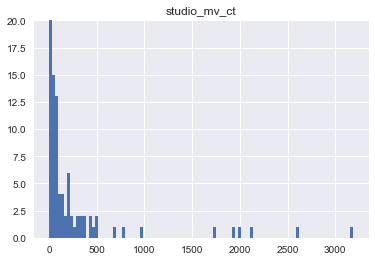

In [21]:
rank_stu.hist('studio_mv_ct', bins = 100)
plt.ylim((0, 20))

In [ ]:
#movie.info()

In [ ]:
#player.info()

In [ ]:
#TODO add features: , n_miss_plr_cols

In [ ]:
player[player['release_date'].isnull()] + 

In [97]:
movie_player.loc[pd.isnull(movie_player['role'])]

movieid                               Title  \
337                   mebeforeyou                       Me Before You   
640   jojodanceryourlifeiscalling  Jo Jo Dancer, Your Life is Calling   
770                           tex                                 Tex   
825                wherehopegrows                    Where Hope Grows   
828             faithofourfathers                Faith of Our Fathers   
833                  hungryhearts                       Hungry Hearts   
844                      exorcist                        The Exorcist   
852             blairwitchproject             The Blair Witch Project   
911              amityvillehorror               The Amityville Horror   
1267                        rings                               Rings   
1280                       forest                          The Forest   
1328                          fog                             The Fog   
1347                    believers                       The Believers   
1370                 poltergeist3                     Poltergeist III   
1372                         gate                            The Gate   
1380                  amityville2       Amityville II: The Possession   
1396                   witchboard                          Witchboard   
1416                        gate2                             Gate II   
1417                 vaticantapes                   The Vatican Tapes   
1418                    abandoned                       The Abandoned   
1419                     babadook                        The Babadook   
1420           masnegroquelanoche              Mas Negro Que La Noche   
1421                          eye                      The Eye (2003)   
1422                juonthegrudge                   Ju-On: The Grudge   
1431                     deadtime                            Deadtime   
1432                        bhoot                               Bhoot   
1433                      inkubus                             Inkubus   
1436                      pulse05                        Pulse (2005)   
1437          phantomofthetheatre              Phantom of the Theatre   
1438             deathofthevirgin                 Death of the Virgin   
...                           ...                                 ...   
2887                   diamondmen                         Diamond Men   
2888                 matandocabos                       Matando Cabos   
2890                     diamonds                            Diamonds   
2897              thisthingofours                  This Thing of Ours   
2898                      dukes08                           The Dukes   
2899                         prey                            The Prey   
2900                 lonelymaiden                   The Lonely Maiden   
3270               privatelessons                     Private Lessons   
3282                  springbreak                        Spring Break   
3301                porkysrevenge          Porky's Revenge (Part III)   
3353                       zapped                             Zapped!   
3392                       tomboy                              Tomboy   
3393                privateschool                      Private School   
3398                   upthecreek                        Up the Creek   
3401              wheretheboysare           Where the Boys Are (1984)   
3404                     mischief                            Mischief   
3419                   hardbodies                          Hardbodies   
3448           lastamericanvirgin            The Last American Virgin   
3458                studentbodies                      Student Bodies   
3462               makingthegrade                    Making the Grade   
3463                    missmarch                          Miss March   
3468                    joysticks                           Joysticks   
3480                     homework                            Homework   
3481       

In [132]:
cond = (pd.isnull(movie_player['role'])) | (pd.isnull(movie_player['playerid']))
a = movie_player.loc[~cond, ['movieid', 'role']]
a = a.drop_duplicates()
#a = pd.pivot_table(a, index = 'movieid', columns = 'role', values = 'playerid')
a

movieid             role
0            forrestgump         Director
1            forrestgump           Writer
2            forrestgump            Actor
5            forrestgump         Producer
6            forrestgump  Cinematographer
7            forrestgump         Composer
8      savingprivateryan         Director
9      savingprivateryan            Actor
16     savingprivateryan         Producer
20     savingprivateryan         Composer
21           pearlharbor         Director
22           pearlharbor           Writer
23           pearlharbor            Actor
31           pearlharbor         Producer
34           pearlharbor         Composer
36             gladiator         Director
37             gladiator           Writer
40             gladiator            Actor
42             gladiator         Producer
43             gladiator         Composer
45          perfectstorm         Director
46          perfectstorm            Actor
50          perfectstorm         Producer
51          perfectstorm         Composer
52              apollo13         Director
53              apollo13            Actor
57              apollo13         Producer
59              apollo13         Composer
60              help2011         Director
61              help2011           Writer
...                  ...              ...
3467     detroitrockcity  Cinematographer
3469            todolist            Actor
3474            todolist         Producer
3475  fraternityvacation            Actor
3476              clerks         Director
3477              clerks           Writer
3478              clerks            Actor
3479          jawbreaker  Cinematographer
3482   butimacheerleader            Actor
3485            mallrats         Director
3486            mallrats           Writer
3487            mallrats            Actor
3489       kingsofsummer         Director
3490       kingsofsummer         Producer
3491             losinit         Director
3492             losinit            Actor
3494            heathers         Director
3495            heathers           Writer
3496            heathers            Actor
3497            heathers         Producer
3499        virginityhit         Producer
3502           somegirls         Director
3503           somegirls            Actor
3504           somegirls         Composer
3505       privateresort            Actor
3506      goingalltheway         Director
3507      goingalltheway            Actor
3509      goingalltheway         Producer
3510      goingalltheway         Composer
3512        inbetweeners            Actor

[1744 rows x 2 columns]

In [133]:
def lala(df):
    return " ".join(list(df['role']))
a = pd.DataFrame(a.groupby('movieid').apply(lala))

In [138]:
a.columns = ['a']

In [139]:
a.loc[a['a'] == "Composer"]

a
movieid                    
americananthem     Composer
blairwitch2        Composer
ghostinthemachine  Composer
heavenhelpus       Composer
omen3              Composer

In [142]:
pd.DataFrame(movie_wide.loc['americananthem'])

americananthem
log_life_gross                            15.3936
life_theater                                  900
log_open_gross                            14.4404
open_theater                                  900
n_miss_mv_cols                                  9
rank_num                                      134
release_yr                                   1986
release_mon                                     6
release_mon2                                   36
release_mon3                                  216
release_wday_num                                5
genre_sd                                     True
genre_cm                                    False
genre_r                                     False
genre_cp                                    False
mpaa_pg13                                       0
mpaa_pg                                         0
runtime_mins                                  129
log_budget_num                            14.5087
log_life_frn_gross                        11.1542
log_avg_open_gross                        6.94601
pct_open_gross                              0.252
ww_log_life_gross                         14.9918
pct_life_gross                           0.526724
studio_mv_ct                                  431
rank_stu                                       73
rank_stu2                                    5329
rank_stu3                                  389017
plr_life_mv_num_Actor_0.0                      32
plr_life_mv_num_Actor_1.0                      28
...                                           ...
open_theater_allyr_Actor_1.0              1183.75
open_theater_allyr_Director_0.0           658.068
open_theater_allyr_Producer_0.0           1373.59
open_theater_allyr_Writer_0.0             667.842
rank_num_allyr_Actor_0.0                  18.5556
rank_num_allyr_Actor_1.0                  16.8889
rank_num_allyr_Director_0.0                     6
rank_num_allyr_Producer_0.0                13.913
rank_num_allyr_Writer_0.0                       6
log_life_gross_diff31_Actor_0.0                 0
log_life_gross_diff31_Actor_1.0                 0
log_life_gross_diff31_Director_0.0              0
log_life_gross_diff31_Producer_0.0              0
log_life_gross_diff31_Writer_0.0                0
log_open_gross_diff31_Actor_0.0                 0
log_open_gross_diff31_Actor_1.0                 0
log_open_gross_diff31_Director_0.0              0
log_open_gross_diff31_Producer_0.0              0
log_open_gross_diff31_Writer_0.0                0
log_life_gross_diff53_Actor_0.0                 0
log_life_gross_diff53_Actor_1.0                 0
log_life_gross_diff53_Director_0.0              0
log_life_gross_diff53_Producer_0.0              0
log_life_gross_diff53_Writer_0.0                0
log_open_gross_diff53_Actor_0.0                 0
log_open_gross_diff53_Actor_1.0                 0
log_open_gross_diff53_Director_0.0              0
log_open_gross_diff53_Producer_0.0              0
log_open_gross_diff53_Writer_0.0                0
n_plrs                                          1

[174 rows x 1 columns]

# pickle

In [76]:
with open('cleaned_data.pkl', 'wb') as picklefile:
    pickle.dump(movie_wide, picklefile)